# Efficiency of Side Channels using Frame Length Modulation for Fling

With [Fling 2.0](https://john.cs.olemiss.edu/~harrison/fling.html), we aim to add spatial awareness and cross-network communications to media devices like TVs
in support of services optimized for user friendliness and that have appropriately
lower security requirements.  

In this jupyter notebook, we analyze the bitrate achieved using frame length modulation. Frame length modulation is used to communicate shared state between a mobile device and a TV. It is assumed that both the TV and the mobile device have Internet connectivity, though they may not be on the same network. This shared state can take the form of a short code or session ID to establish communications via an Internet relay.

## Motivation

We are considering mechanisms for establishing communications between a mobile device and a TV for low-security promiscuous services, where policies based on human boundaries with human enforcement provide sufficient protection. Not all services require usernames, passwords, or two-factor authentication due to the nature of the data being communicated or the services being offered. Here are a few examples to underscore this:

* Airplay / Chromecast: If a visitor to your home casts inappropriate content to your TV then kick the visitor out.
* Jukebox: Imagine Pandora or Spotify could take into account the preferences of all present.

For such services, being on the same network is not as important as being in the same room, within earshot, or within the viewing angle of the TV. Requiring an individual to obtain a password and authenticate to a wireless network to experience these services introduces unnecessary friction.

We use the term spatial awareness to refer to the understanding of real-world physical boundaries, such as walls and doors, which divide space into rooms, homes, apartments, floors, etc. It also includes awareness of the relative locations of devices and potentially people within these spaces.

WiFi Direct partially addresses the problem but still requires a “join the network” step and does not consider real-world boundaries. We aim to replace network boundaries with more intuitive delineations like “same room,” “same apartment,” “same house,” “same floor,” and “same coffee shop.” We believe these physical delineations are more understandable than network boundaries.

Additionally, we want to do this without requiring any modifications to existing 
mobile device hardware or operating systems.

This leaves us with at least three subproblems:

* Adding spatial awareness of TVs (or other media devices),
* Enabling a communications pathway that spans networks,
* Identifying devices but only when appropriate for the application.

In this analysis, we focus solely on the second subproblem: enabling a
communications pathway that spans different networks.

## Enabling Communications Spanning Networks

In our context, spanning networks means establishing communications
between devices that are connected to the Internet but not necessarily
on the same local network. For example, one device might be connected
via 5G while another is connected via Wi-Fi.  Instead of network boundaries,
we want to enable communications based on physical-world, human-understable
boundaries.  We assume that the Internet and proximal wireless
communications are the only reliable common denominators.

Proximal wireless communications refers to devices being sufficiently
close to one another that at least one appropriately equipped device
can see the EM emissions of the other.  Proximal wireless communication 
does not imply that the devices can authenticate to each other or that 
they use identical technologies.

Additionally, as already stated, we do not want to modify existing mobile
device hardware or operating systems.

Despite these constraints, we allow for modifications to TVs or
other media devices, mobile apps or web pages, and servers communicating
with these apps, web pages, and TVs. This leaves us with feasible
solutions that involve one-sided (TV) hardware upgrades, extensive
modifications to TV and server software, and adding operations performed
by mobile apps or web pages within their security sandboxes.

### Hardware Modifications

Today’s mobile devices primarily use Wi-Fi, 5G, and to a lesser 
extent, LTE.  For a forward-looking solution, Fling 2.0 focuses
on Wi-Fi, 5G, and eventually 6G.  In this notebook, we limit the
problem to only cross-network communications between devices on
different Wi-Fi networks.  We need TV hardware that can operate
across the spectrum used by most mobile devices today, approximately
600 MHz to 6 GHz. This can be achieved with tri-band antennas and
dual, concurrent software radio stacks: one for existing Wi-Fi and
another for broader spectrum reception to enable spatial awareness
and cross-network communications.

We can simplify the problem somewhat by separating cross-network 
communications into two stages: 
    
1) **Initial Stage**: Communicating a short code between the mobile device and the TV.

2) **Second Stage**: Using the short code to set up a higher bitrate channel through an Internet relay.

The first stage could work with a low bitrate, potentially very-low
bitrate communications channel.  Authentication and encryption
complicate this communication.  Authentication is meant to prevent
communication except between authorized parties.  For 
flings, we want to enable communications even when the communicating
parties are not authenticated.  Provided of course that the 
communications are only being used for promiscuous services
for which the human user has consented.

### Software Modifications

One way to enable low bitrate communications is via a side channel.
A side channel is an alternative communication pathway that leverages
indirect information or signals to transmit data.  Side channels
may communicate via variations in timing, power consumption,
electromagnetic emissions, or other observable properties.

We are limited to side channels feasible within web or app
security sandboxes. *Sandboxed applications* (web pages and
mobile apps) can manipulate the mobile device in ways observable
to an extended TV, such as opening connections and using TCP or UDP.

In this document, we focus on one possible side channel:
Wi-Fi *frame length modulation.*

In the context of Fling, frame length modulation involves
manipulating Wi-Fi frame lengths to achieve robust,
low bitrate communications over short ranges, such as
within a house or apartment. This low bitrate communication
is used for the initial stage of cross-network communications,
specifically for communicating a short code.

Frames with modulated lengths are hereafter referred to as 
*side channel frames*.

## Frame Length Modulation

Communications between mobile devices and Internet servers are typically encrypted. For instance, Wi-Fi frames may utilize encryption standards such as WPA2 or WPA3. Even within the same Wi-Fi network, WPA2 and WPA3 employ pairwise encryption between the access point and each mobile device, affecting only the payload and not the Wi-Fi frame headers. Consequently, while we cannot use side channels based on manipulating IP, TCP, UDP, SCTP, or DTLS header fields, we are able to read Wi-Fi frame headers and deduce the payload length, albeit with certain caveats.

### Caveats:

1. *Payload Alignment:* Wi-Fi encryption algorithms require that the encrypted portion of the frame adheres to size constraints—it must be a multiple of 8 or 16 bytes, depending on the encryption standard. AES, the most common encryption standard in modern Wi-Fi networks, requires 16-byte blocks.  Without decrypting, we cannot infer how many bytes of padding were added. To ensure alignment, we can construct payloads in multiples of 16 bytes.

2. *Encryption Header Variations:* Different encryption algorithms
may have different header sizes dedicated to encryption. However,
the number of variations is limited and thus we can account
for these variations when constructing packets of a desired length.

### Modulation Directions:

Frame length modulation could potentially be performed in either
the upstream or downstream direction using TCP or UDP, such as
through WebRTC.  The following discussion of trade-offs 
does not depend on the choice of TCP or UDP.

In the downstream direction, the server implements *fling initiator
beacon* as show in

<table style="margin-left: auto; margin-right: auto; align:center">
<tr>
    <td>
        <img src="downstream.png" alt="Downstream" width="500" style="display:block; margin:auto;"/>
    </td>
</tr>
<tr>
    <td>
        
**Figure 1**: Downstream Frame Length Modulation
    </td>
</tr>    
</table>

**Downstream Advantages:**

- *Control Over Server:*  We can modify any part of the network
  and web stacks to precisely control TCP segmentation or the
  size of UDP datagrams, including the manipulation of optional
  headers in IP, SCTP, and similar protocols.
  
- *Large Frame Sizes:* The majority of frames will be large (close to the path MTU), and this is true whether the downstream carries video streams, file downloads, or web traffic.  Even moderately sized HTML files will span multiple TCP segments.  This
means there would be less interference with the shorter packets used
for frame length modulation.

- *Higher Bitrates:* Asymmetric networks typically feature higher downstream bitrates, allowing proportionally faster side channel communication. 

**Downstream Disadvantages:**

- *Beamforming*: Wi-Fi Access Points (APs) may
use beamforming to deliver frames to the mobile device.  If the
TV is not in the line-of-sight between the AP and the mobile
device, it may not capture the frames carrying the side channel.
Figure 1 shows a cone representing beamforming from a Wi-Fi
basestation.


**Upstream Advantages:**

- *Omnidirectional:* Mobile devices often use omnidirectional
transmissions, increasing the likelihood that a TV within
range can intercept side channel frames.

**Upstream Disadvantages:**

- *Sandbox Limitations:* Mobile apps and web pages have
less control over TCP packetization, although this issue
is less pronounced with UDP. Web pages can use UDP via WebRTC.
WebRTC was introduced for peer-to-peer communications, but
it can be used for server-client communications.

- *Small Frame Interference:* When download web resources or files
or when streaming audio or video, the downstream is comprised of
large packets while the upstream is typically composed of acknowledgements
and HTTP requests.  The prior may have zero payload and the latter tend
to be short.  Short frames will more likely interfere with frame-length
modulated side channel frames.

If beamforming rarely affects intercepting side channel traffic
then the tradeoff appears to favor frame length modulation
in the downstream direction.

### Bidirectional Modulation:

With bidirectional frame-length modulation, both the 
mobile device and the server agree on a short code
and then communicate the same short code in both 
upstream and downstream directions.  This method
benefits from precise control over packet lengths
and reduced interference from smaller packets.
However, if beamforming disrupts downstream reception,
the TV might still capture the short code in the upstream
direction, albeit more slowly if there is significant
interference from short frame non-side channel traffic
or due to high bandwidth asymmetry.

**Disadvantages:**

- *Increased Traffic and Complexity:* Bidirectional frame length modulation adds overhead 
in both directions, and increases implementation complexity.
Empirical studies may decide whether there is any need
for bidirectional frame length modulation.

## Upstream Frame Length Modulation

<table style="margin-left: auto; margin-right: auto; align:center">
<tr>
    <td>
        <img src="upstream.png" alt="Upstream" width="500" style="display:block; margin:auto;"/>
    </td>
</tr>
<tr>
    <td>
        
**Figure 2**: Upstream Frame Length Modulation
    </td>
</tr>    
</table>

The *Fling Initiator Beacon (FIB)* is the component, such as
a javascript library, that creates the side channel that 
communicates the short code.  For upstream frame length
modulation, the FIB executes within the mobile device.  The FIB
is thus constrained to the behaviors allowed by a web or mobile
security sandbox.  As an aside, with downstream frame length
modulation, the FIB executes on the server-side and thus
would NOT be constrained to a web or mobile
security sandbox.

The Fling Beacon Detector (FBD) is the hardware and software
within the TV or media device that detects and then decodes
the side channel emitted by the FIB.  

In following sections we consider two different upstream
frame length modulation solutions: one based on WebRTC and the
other based on WebTransport.   Both WebRTC and WebTransport
can transmit datagrams, and as long as datagrams are smaller
than the path MTU, both WebRTC and WebTransport maintain
a one-to-one mapping between datagrams and packets.  Thus,
the FIB can modulate datagram length to modulate packet length
which in turn modulates frame length. However, WebTransport
uses variable length headers, which complicates
frame length modulation.

Adjusting the payload length is called *payload length modulation*
and the resulting length is the *modulated payload length*.  

WebRTC sends data communications using UDP datagrams.  Within
each UDP datagram, the payload is encapsulated within
Datagram-Transport Layer Security (DTLS) and the Stream 
Control Transmission Protocol (SCTP).  WebTransport
eschews UDP, DTLS, and SCTP in favor of QUIC and TLS.  
WebTransport is newer and less supported Internet transport
protocol, but it is supported by Chrome and Chromium-based 
browsers.  As of this writing, it is not supported by Safari
and Firefox.

For purposes of the following analyses, the device running the FIB
communicates over a wireless network using WPA2 (AES-CCMP).
AES adds padding to obtain 16 byte block sizes for the
entire encrypted portion of the Wi-Fi frame.  

The FBD is not necessarily on the same Wi-Fi network with 
FIB and thus is assumed to have neither the Wi-Fi network's
Pre-Shared Key (PSK) or any mobile device's Pairwise Transient
Key (PTK).  As such the FBD cannot decrypt the AES encrypted headers.

Without decrypting, the FBD cannot infer how many bytes of padding
were added to meet AES block size alignment requirements.  However, 
when communicating bit values such as 000 or 001 through our side
channel the FBD can disambiguate these values provided the payload
length for 000 and 001 are different multiples of the AES block size
(see Table 1).

<table align="center">
<tr><td>

| Modulated Payload Length (bytes) | Side Channel Bits | 
| -------------------------------- | ------------------|
|   0                              | $000$             |
|   16                             | $001$             |
|   32                             | $010$             |
|   64                             | $011$             | 
|   ...                            | ...               |
</td></tr>
<tr><td align="center">
    
**Table 1:** Side channel communicates binary values by modulating payload length.

</td></tr>
</table>

It is up to the FBD to infer a baseline length for frames
that is not part of the payload.  The FBD subtracts this baseline
length from all side channel frames in order to infer 
the *modulated payload length* and then divides by the
AES block size to obtain the binary value encoded
in the side channel.

### WebRTC-based Upstream Frame Length Modulation


For this analysis, we assume the FIB uses WebRTC from a web 
page or mobile app.  The FIB initiates a WebRTC connection 
like the following:

    const peerConnection = new RTCPeerConnection({
        iceServers: [{ urls: 'flingo.org:19302' }]
    });

    // Create a data channel with no reliability and no reordering
    const dataChannel = peerConnection.createDataChannel("sideChannel", {
        ordered: false,  // Disable reordering of messages
        maxRetransmits: 0  // Disable retransmissions
    });

    [...]

To communicate the bit sequence through the side channel [001,
010, 011, 100] we might do the following:

    dataChannel.onopen = function() {
        // Example payload lengths
        const lengths = [16, 32, 64, 128];

        lengths.forEach(length => {
            let payload = new Uint8Array(length);
            payload.fill(0);  // Fill the payload with zeros
            dataChannel.send(payload);
        });
    };


WebRTC using UDP requires both SCTP and DTLS.  DTLS provides
datagram encryption, although we are only communicating a 
short code via frame lengths and thus the contents of the
payloads are inconsequential.  This is why in the example
above the payloads are filled with zeroes.  SCTP provides
reliable, in-order delivery although we can 
turn off these features if we do not want them.  Turning off
reliability and in-order delivery does not remove the 
requirement for having a SCTP header because it also 
provides congestion avoidance.

Although the modulated payload lengths are multiples of the 
AES block size, the FDB must establish a baseline length
that it can subtract away to obtain the baseline length from
the frame length to obtain the modulated payload length.

The baseline frame length is sum of the lengths of all components
of a frame that do not vary in length on the timescales over which we 
communicate a short code.  We may be able to explicitly account
for variations in unencrypted headers, but we cannot do that so 
easily for the portions of a Wi-Fi frame that are encrypted.
Table 2 shows which headers are encrypted and their typical lengths.

<table align="center">
<tr><td>

| Component                | Length (bytes) | Encrypted (Yes/No) |
| ------------------------ | -------------- | ------------------ |
| 802.11 Wi-Fi Header      | 24             | No                 |
| CCMP Header              | 8              | No                 |
| IP Header (IPv4)         | 20             | Yes                |
| UDP Header               | 8              | Yes                |
| DTLS Overhead            | 13             | Yes                |
| SCTP Header              | 12*            | Yes                |
| SCTP DATA Chunk Header   | 16             | Yes                |
| Data Chunk Payload       | varies         | Yes                |
| MIC                      | 8              | Yes                |
| Padding                  | varies         | Yes                |
| FCS                      | 4              | No                 |

</td></tr>
<tr><td align="center">
    
* Although the SCTP header has fixed length, SCTP breaks up the payload
into chunks.
    
**Table 2:** Components of an 802.11 Wi-Fi Frame communicating a WebRTC Data Chunk.

</td></tr>
</table>

IPv4 has optional headers, but they are typically used only for
diagnostics.

SCTP does not have optional headers, but breaks up its payload into
chunks. Each chunk has its own header.  There are many different types
of chunks.  Some occur only during connection initiation or shutdown
and thus do not affect frame length modulation.  Some are less
commonly used and thus can be ignored.  Some only occur in exceptional
circumstances such as ERROR and ABORT: these also can be ignored.
After a connection has been established, datagrams will usually carry
only one of three types of chunks: DATA, SACK, and HEARTBEAT.
HEARTBEAT chunks are typically sent periodically, but on long enough
timescales that they are not likely to interfere with upstream frame
length modulation.  When a HEARTBEAT CHUNK happens to appear in the
same frame with a DATA CHUNK, we will have to detect this using FEC or
a MIC in the side channel data. This leaves DATA and SACK chunks. We
believe that SCTP implementations will not send SACK chunks in the
upstream direction if no DATA chunks are being sent in the downstream
direction.  Therefore, only DATA chunks remain of concern.  Since a
DATA CHUNK header has fixed length, we can count this as part of the
baseline length.

Frame length excluding variable components: 24 + 8 + 20 + 8 + 13 + 12 + 16 + 8 + 4 = 113 bytes

The unencrypted part of the frame is 36 bytes.

Let's refer to the encrypted portion of the frame excluding the padding as the *unpadded
block*.   When we add padding, we use the term *padded block* to refer to all encrypted 
portions of the packet.  For AES, the *padded block* always has a length that is a
multiple of 16.

A minimum sized unpadded block has no payload and thus has a length of
20 + 8 + 13 + 12 + 16 + 8 = 77 bytes.  77 bytes is 3 bytes short of a 
multiple of 16. The padded block thus has length 77+3 = 80 bytes

A minimum sized frame would thus be 36 + 80 = 116 bytes. 
We use 116 as the baseline frame length.

We can expand the payload in increments of 16 bytes to establish our side channel.
Thus, for this analysis we assume that side channel frames have lengths
116, 132, 148, and so on.  Each muliple of 16 added to 116 communicates
a different binary number via the side channel as shown in Table 3.

<table align="center">
<tr><td>
    
| Frame Length (bytes) | Side channel (binary) | 
| -------------------- | ----------------------|
|   116                | $000$                 |
|   132                | $001$                 |
|   148                | $010$                 | 
|   ...                | ...                   |

</td></tr>
<tr><td align="center">
    
**Table 3:** Side channel communicates binary values by modulating frame length.

</td></tr>
</table>


<table style="margin-left: auto; margin-right: auto; align:center">
<tr>
    <td>
        <img src="webrtc_frame.png" alt="WebRTC" width="800" style="display:block; margin:auto;"/>
    </td>
</tr>
<tr>
    <td>
        
**Figure 3**: Components of a WebRTC frame and associated constants and variables.
    </td>
</tr>    
</table>
Each side-channel length encodes one possible binary number starting from 0.

Let $C$ = the desired number of bits to communicate in a short code.
  For now, I assume 32 bits is enough.
  
Let $H$ = number of bits allocated to fields whose length cannot be 
modulated.  This includes headers and padding.  This is the baseline frame length
in bits = 116 * 8 = 928.

Let $\overline{L}$ = average side channel frame length in bits. 

Let $L$ = maximum frame length of side channel frames in bits.

Let $n$ = number of distinct side channel frame lengths.

Let $B$ = block length requirement in bits.  For AES this is 16 bytes, 
i.e., 128 bits.

The maximum length is thus given by 

<table width="80%">
<tr><td width="100%" align="center">
    
$$
L = H + (n-1)B
$$

</td>
<td width="0%" align="right">(1)</td></tr>
</table>

Assume that all valid values that the side channel can take are equally 
likely, as we are using the side channel to communicate a random 
short code.  Thus the average frame length in bytes is 

<table width="80%">
<tr><td width="100%" align="center">

$$
\overline{L} = \frac{H + L}{2}
$$

</td>
<td width="0%" align="right">(2)</td></tr>
</table>

The number of side channel data bits communicated with a 
single correctly received frame is

<table width="80%">
<tr><td width="100%" align="center">

$$
\log_2 \big(1 + \frac{L-H}{B}\big)
$$

</td>
<td width="0%" align="right">(3)</td></tr>
</table>

The efficiency ($\eta$) is defined as

<table width="80%">
<tr><td width="100%" align="center">
    
$$
\eta = \frac{\text{side channel data bits}}{\text{all side channel bits}}
$$

</td>
<td width="0%" align="right">(4)</td></tr>
</table>


All side channel bits refers to all bits transmitted needed to communicate the 
side channel data including the zeroes packed into the frames whose lengths are being modulated. Substituting (3) into (4) yields

<table width="80%">
<tr><td width="100%" align="center">

$$
\eta = \frac{\log_2 \big(1+\frac{L-H}{B}\big)}{\overline{L}}
$$

</td>
<td width="0%" align="right">(5)</td></tr>
</table>

Then substituing (2) into (5) yields

<table width="80%">
<tr><td width="100%" align="center">

$$
\eta = \frac{2 \big(\log_2 (1 + \frac{L-H}{B})\big)}{H + L}
$$

</td>
<td width="0%" align="right">(6)</td></tr>
</table>

In Equation (6),  $H$ and $B$ are constants.  Thus efficiency becomes a function of $L$.



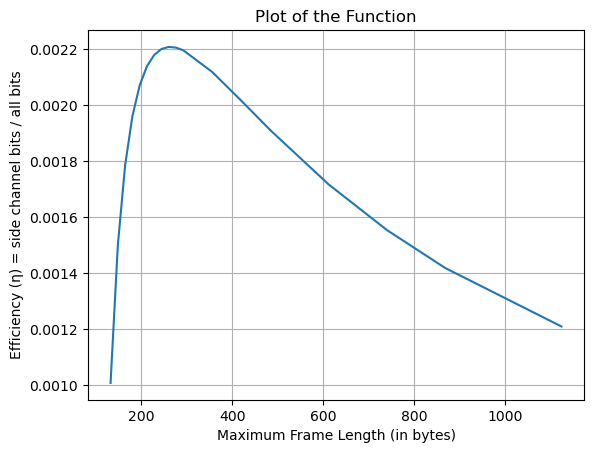

Frame lengths: [ 132.  148.  164.  180.  196.  212.  228.  244.  260.  276.  292.  356.
  420.  484.  612.  740.  868. 1124.] bytes
argmax(Y)=8
Number of different lengths at maximum efficiency: 10
Max efficiency in side channel bits / bits transmitted is 0.002208728786494257
Most efficient maximum frame length is 260.0 bytes
Most efficient average frame length is 188.0 bytes
Bits communicated in a single frame at most efficient length is 3.321928094887362


In [55]:
import numpy as np
import matplotlib.pyplot as plt


H = 116*8  # overhead in bits.  These are allocated to headers.
B = 16*8   # all encrypted payloads must have lengths in bits that are a multiple of B.

n = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 20, 24, 32, 40, 48, 64])
L = H + (n-1) * B

def side_bits(L, H, B):
    return np.log2(1+(L-H)/B)
    
# Function represents number of bits communicated via a side channel
# over the number of bits transmitted.
def efficiency(L, H, B):
    return 2 * side_bits(L, H, B) / (H + L)

# Compute the function values
Y = efficiency(L, H, B)

# Plotting the function
plt.plot(L/8, Y)
plt.xlabel('Maximum Frame Length (in bytes)')
plt.ylabel('Efficiency (η) = side channel bits / all bits')
plt.title('Plot of the Function')
#plt.legend()
plt.grid(True)
plt.show()

best_max_len = L[np.argmax(Y)]  # in bits
best_avg_len = (best_max_len + H) / 2  # in bits
bits_per_frame = side_bits(best_max_len, H, B)
print(f"Frame lengths: {L/8} bytes")
print(f"argmax(Y)={np.argmax(Y)}")
print(f"Number of different lengths at maximum efficiency: {n[np.argmax(Y)]}")
print(f"Max efficiency in side channel bits / bits transmitted is {np.max(Y)}")
print(f"Most efficient maximum frame length is {best_max_len/8} bytes")
print(f"Most efficient average frame length is {best_avg_len/8} bytes")
print(f"Bits communicated in a single frame at most efficient length is {bits_per_frame}")

In [ ]:
# Plot number of bits per frame as a function of frame length.

How many frames do we need to communicate X bit short code with frames of most efficient frame lengths?


In [51]:
from math import ceil
short_bits = 32    # number of bits in the short code.
frames = ceil(short_bits/bits_per_frame)
print(f"Number of frames to reach {short_bits} bit short code is {frames}.")

Number of frames to reach 32 bit short code is 10.


If we were to send the packets as a burst and there is no interference, how
much time would it take to broacast the short code on a 100 Mbps Wi-Fi?


In [52]:
secs_to_fib = frames * best_avg_len / 100e6
print(f"Average time to send a FIB is {secs_to_fib} seconds at 100 Mbps.")

Average time to send a FIB is 0.0001504 seconds at 100 Mbps.


## Detecting Side Channels and Disambiguating Side Channel Data Carrying Frames

To disambiguate the side channel frames, we could introduce two types of side channel
frames:

* *Presence frames* indicate the presence of the side channel.
* *Data frames* carry data such as a short code or session ID.

Presence frames could have magic frame lengths otherwise unused to communicate
side channel data.  Presence frames could follow a repeating sequence
of length $k$.  This sequence is called the *presence sequence*.

When the presence sequence is detected witin a time interval,
the FBD may then incur additional traffic analysis to extract and decode the side
channel data frames.

Since presence frames would always be present when the side channel is active,
we could choose to use the smallest frames used by the side channel.  We could just choose
a rotating ascending sequence $H, H+B, H+2B, \cdots , H+(k-1)B$ where $H$ 
is the smallest frame length in the presence sequence in bits, and $k$ 
is the number of frames in the presence sequence.  Data frames would thus
have lengths starting at $H+kB$ and going upward from there.

We could send frame pairs, wherein the first in each pair is a presence
frame and the next is a data frame.  The presence frames would represent
overhead.

Let $L_p$ denote the length of presence frames of which $\overline{L}_p$
denotes the average length of presence frames.  If we assume that
presence frames rotate through the ascending sequence then the average

$$
\overline{L}_p = \frac{1}{k}(H + (H + B) + (H + 2B) + \cdots + (H + (k-1)B)) = H + B(k-1)/2
$$

We can then rewrite the efficiency as 

$$
\eta = \frac{\log_2 \frac{L-(H+kB)}{B}}{\overline{L} + \overline{L}_p}
$$

Except the average length ($\overline{L}$) of side channel data frames also changes, 
since the smallest data frame length is $H + kB$.  Thus,

$$
\overline{L} = \frac{1}{2}(H + kB + L)
$$

the lengths spanned by side channel data frames becomes

$$
[L-(H+kB), L]
$$

and efficiency ($\eta$) is still

$$
\eta = \frac{\text{side channel data bits}}{\text{all side channel bits}}
$$


$$
\eta = \frac{\log_2 \big(1+\frac{L-H}{B}\big)}{\overline{L}} = \frac{2 \big(\log_2 (1 + \frac{L-H}{B})\big)}{H + L}
$$

$$
\eta = \frac{\log_2 \frac{L-(H+kB)}{B}}{(H + kB + L)/2 + H + B(k-1)/2}
$$

$$
\eta = \frac{2 \log_2 \frac{L-(H+kB)}{B}}{H + kB + L + 2H + B(k-1)}
$$

$$
\eta = \frac{2 \log_2 \frac{L-(H+kB)}{B}}{3H + B(2k-1) + L}
$$

I am interested in plotting the efficiency as a function of maximum frame length $L$.
$H$ and $B$ are constants, but we are left with one parameter free to vary: $k$, 
the number of presence 
frames in the presence sequence.




## Disambiguating Optional Encrypted Headers

In the way we have forumulated the problem of frame length modulation,
headers represent overheead in the sense that we cannot modulate header
lengths.  However, this does not mean that header lengths are always 
constant as shown described below, encrypted portions of the frame can 
have variation in lengths outside the control of the Fling Initiator
Beacon (FIB):

* IP (IPv4): Yes, optional headers
* IP (IPv6): No, but it has extension headers.
* UDP: No optional headers.
* SCTP: Yes, optional headers (in the form of optional chunks).
* DTLS: No optional headers, but has optional handshake messages and extensions.

Accounting for all variations in headers and their lengths may be difficult.
If we want something that will handle a modicum of variation in overhead 

If there are the same encrypted option headers are present in all
side channel frames then the side channel may become undetectable
as we have described frame length modulation so far.

We could solve the problem by not using absolute frame lengths to 
represent the presence sequence.  Instead we could look for a sequence 
of frame lengths that obey relative lengths.   The first length in the
sequence should be offset by the size of the offending optional header
rounded up to align with encryption block boundaries.  Once we have
detected the sequence we can subtract the minimum length in the sequence
$L_{min}$ from our expected header lengths $H$.  When decoding all data
frames, we merely subtract $L_{min} - H$ from each frame length before
proceeding with decoding as if there were no encrypted optional headers
present.

